In [1]:
import numpy as np
import astropy.io.fits as fits 
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from matplotlib import gridspec
from scipy import ndimage
from scipy.optimize import least_squares
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import pyneb as pn
from astropy.modeling import models, fitting

In [2]:
def flux_ratio(amp_SII6716_fit,amp_SII6731_fit,amp_SII6716_br_fit,amp_SII6731_br_fit):
    ratio_core = (amp_SII6716_fit/amp_SII6731_fit)
    ratio_wing = (amp_SII6716_br_fit/amp_SII6731_br_fit)
    return ratio_core,ratio_wing 

def electron_density(ratio_core,ratio_wing):
    S2 = pn.Atom('S',2)
    Ne_core = S2.getTemDen(int_ratio=ratio_core,tem=1e4,wave1=6717,wave2=6731)
    Ne_wing = S2.getTemDen(int_ratio=ratio_wing,tem=1e4,wave1=6717,wave2=6731)
    return Ne_core, Ne_wing

def int_spec(mini_cube,mini_err):  # sums all spectra around choice of pixel 
    shape = mini_cube.shape[1]*mini_cube.shape[2]
    int_spectrum = sum(mini_cube[:,i,j] for i in range(mini_cube.shape[1]) for j in range(mini_cube.shape[2]))
    int_error = np.sqrt(sum((mini_err[:,i,j])**2 for i in range(mini_cube.shape[1]) for j in range(mini_cube.shape[2])))
    return int_spectrum,int_error

def redshift(vel):
    return vel/300000.0

def line_width(vel_sigma,rest_line,inst_res_fwhm=2.5):
    sigma = vel_sigma/(300000.0-vel_sigma)*rest_line
    return np.sqrt(sigma**2+(inst_res_fwhm/2.354)**2)

def gauss(wave,amplitude,vel,vel_sigma, rest_wave):
    line = (amplitude)*np.exp(-(wave-(rest_wave*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_wave))**2))
    return line 

def Ha_gauss(wave,amp_Ha,vel,vel_sigma):
    Ha = gauss(wave,amp_Ha,vel,vel_sigma,6562.85)
    return Ha

def NII_doublet_gauss(wave,amp_N6583,vel,vel_sigma):
    N_6548 = 0.33*gauss(wave,amp_N6583,vel,vel_sigma,6548.05)
    N_6583 = gauss(wave,amp_N6583,vel,vel_sigma,6583.45)
    return N_6548+N_6583

def SII_doublet_gauss(wave,amp_S6716,amp_S6731,vel,vel_sigma):
    S_6716 = gauss(wave,amp_S6716,vel,vel_sigma,6716.44)
    S_6731 = gauss(wave,amp_S6731,vel,vel_sigma,6731.82)
    return S_6716+S_6731

def full_gauss(p,wave,data,error):    
    (amp_Ha,amp_Ha_br,amp_N6583,amp_N6583_br,amp_S6716,amp_S6716_br,amp_S6731,amp_S6731_br,vel_core,vel_core_sigma,vel_wing, vel_wing_sigma,m,c) = p 
    narrow_Ha = Ha_gauss(wave,amp_Ha,vel_core,vel_core_sigma)
    broad_Ha = Ha_gauss(wave,amp_Ha_br,vel_wing,vel_wing_sigma)
    narrow_NII = NII_doublet_gauss(wave,amp_N6583,vel_core,vel_core_sigma)
    broad_NII = NII_doublet_gauss(wave,amp_N6583_br,vel_wing,vel_wing_sigma)
    narrow_SII = SII_doublet_gauss(wave,amp_S6716,amp_S6731,vel_core,vel_core_sigma)
    broad_SII = SII_doublet_gauss(wave,amp_S6716_br,amp_S6731_br,vel_wing,vel_wing_sigma)
    cont = (wave/1000.0)*m+c
    return (narrow_Ha+broad_Ha+narrow_NII+broad_NII+narrow_SII+broad_SII+cont-data)/error

def flux(data,sigma_eff):
    flux1 = np.sum(data)*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff))
    flux = flux1*(10**(-20)) 
    return flux

def lum(z,flux):
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    Hb_lum = np.log10(4*np.pi)+2*np.log10(dist.value)+np.log10(flux)
    return Hb_lum

def line_width_recons(vel_sigma,rest_line,inst_res_fwhm=0):
    sigma = vel_sigma/(300000.0-vel_sigma)*rest_line
    return np.sqrt(sigma**2+(inst_res_fwhm/2.354)**2)

In [3]:
#hdu = fits.open('3C264_DATACUBE.fits')
hdu = fits.open('3C264-1s-hanii-STARSUB.fits')
#hdu.info()
qso_data = hdu[1].data
qso_error = hdu[2].data
qso_header = hdu[1].header
wavestart = qso_header['CRVAL3']
wavint = qso_header['CD3_3']
#wave = wavestart+np.arange(qso_data.shape[0])*wavint. This is the same as the one below. 
[central_x,central_y]= [55,58]#
qso_data[np.isnan(qso_data)] = 0.0000001
qso_error[np.isnan(qso_error)] = 0.000001
#(central_y,central_x) = ndimage.measurements.maximum_position(qso_data[1584,:,:])

In [4]:
z = 0.02172
k = 1+z
c = 300000
central_vel = c*z

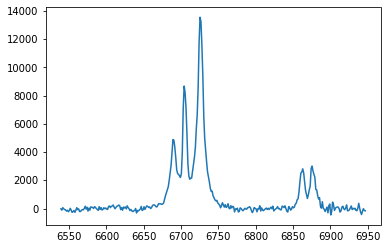

In [5]:
wave = np.arange(wavestart,(wavestart+(wavint*qso_data.shape[0])),wavint)#start,stop,step
select =(wave>6400*k)&(wave<6800*k)
x0 = 55
y0 = 58
x = wave[select]
data = qso_data[:,y0-1:y0+2,x0-1:x0+2][select]
data_err = qso_error[:,y0-1:y0+2,x0-1:x0+2][select]
(y,y_err) = int_spec(data,data_err) 
plt.plot(x,y)
plt.show()

In [6]:
# lower_bounds = [0,0,0,0,0,0,0,0,central_vel - 1000,0,central_vel - 1000,0,-np.inf,-np.inf]
# upper_bounds = [np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,central_vel + 1000,200,central_vel + 1000,600,np.inf,np.inf]
# bounds_p_init = (lower_bounds,upper_bounds) 
        
# result = least_squares(full_gauss,x0=[300,30,100,10,10,1,10,1,6516,100,6416,200,0,2],bounds=bounds_p_init,args = (x,y,y_err),max_nfev=10000000)
# popt = result['x']

popt,pcov1 = leastsq(full_gauss,x0=[850,80,856,640,195,87,176,140,6516,100,6416,200,-3,18],args = (x,y,y_err),maxfev=10000000)

print(popt)
[amp_Ha,amp_Ha_br,amp_N6583,amp_N6583_br,amp_S6716,amp_S6716_br,amp_S6731,amp_S6731_br,vel_core,vel_core_sigma,vel_wing,vel_wing_sigma,m,c] = popt

[7165.27041795  990.04077576 8260.86908777 5700.26039171 2235.12304251
  535.6793327  1488.00963663  993.7413994  6497.65786277  100.39239781
 6497.13017652  364.45637736 -111.46932334  765.55195938]


Text(0, 0.5, 'Residuals')

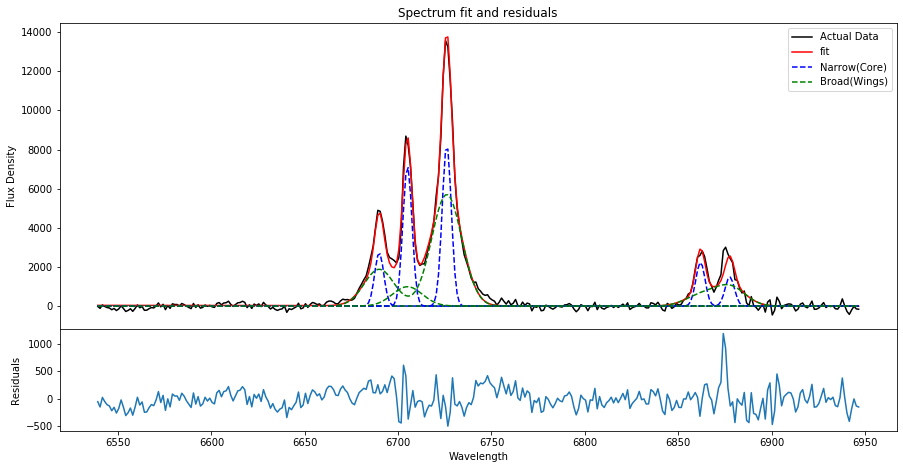

In [7]:
fit = full_gauss(popt,x,y,y_err)*(y_err)+y
residual = y - fit

plt.figure(figsize=(15,7.5))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # # set height ratios for sublots

ax1=plt.subplot(gs[0])  # first subplot
ax1.plot(x,y,'-k',label='Actual Data')
ax1.plot(x,fit,'-r',label='fit')

plt.plot(x,NII_doublet_gauss(x,amp_N6583,vel_core,vel_core_sigma),'--b')#,label='NII6583')
plt.plot(x,NII_doublet_gauss(x,amp_N6583_br,vel_wing,vel_wing_sigma),'--g')#,label='NII6583_br')
plt.plot(x,SII_doublet_gauss(x,amp_S6716,amp_S6731,vel_core,vel_core_sigma),'--b',label = 'Narrow(Core)')
plt.plot(x,SII_doublet_gauss(x,amp_S6716_br,amp_S6731_br,vel_wing,vel_wing_sigma),'--g',label='Broad(Wings)')
plt.plot(x,Ha_gauss(x,amp_Ha,vel_core,vel_core_sigma),'--b')
plt.plot(x,Ha_gauss(x,amp_Ha_br,vel_wing,vel_wing_sigma),'--g')

plt.title('Spectrum fit and residuals')
plt.ylabel('Flux Density')
plt.legend()

ax2=plt.subplot(gs[1])  # second subplot
plt.plot(x,residual)
plt.subplots_adjust(hspace=0)
plt.xlabel('Wavelength')
plt.ylabel('Residuals')

In [8]:
sigma = line_width_recons(popt[9],6562.8)  # core
HaFlux = flux(popt[0],sigma)
print(HaFlux)

3.945814084098011e-16


In [9]:
HaLum = lum(z,HaFlux)
print(HaLum)  # in log. ergs

38.62560156906943


In [10]:
SFR = (7.9*10**(-42))*(10**HaLum) # star formation rate
print(SFR)

0.003336020113056123


In [40]:
sigma_br = line_width_recons(popt[11],6562.8)  # wing
Ha_br_flux = flux(popt[1],sigma_br)
print(Ha_br_flux)

1.980999701507669e-16


In [42]:
HaLum_br = lum(z,Ha_br_flux)
print(HaLum_br)

38.326349360532234


In [43]:
ratio_wing = popt[5]/popt[7]
ratio_core = popt[4]/popt[6]
print(ratio_wing,ratio_core)

# N2/Ha and O3/Hb

0.5390530504397042 1.502089091020698


In [44]:
Ne_core,Ne_wing = electron_density(ratio_core,ratio_wing) # star formation is low, and really high density gas being expelled
print(Ne_wing)

5280.339613224045


In [45]:
M_ion = (3.4*10**6)*(100/Ne_wing)*((10**HaLum_br)/10**41)  #eqn3 from: 1905.10385
print(M_ion)

136.51061455970105


In [20]:
y, x = np.mgrid[:45,:45]#creates array 45x45 in which we then write to. 
hdu = fits.open('subcube_par_3C264_45x45_spec_HbO3.fits')

Hb = hdu[1].data
OIII = hdu[2].data

hdu.close()

In [21]:
amp_Hb = np.max(Hb)
amp_OIII = np.max(OIII)

In [22]:
hdu = fits.open('subcube_par_3C264_err_45x45_spec_HbO3_100loops.fits')

Hb_err = hdu[1].data
OIII_err = hdu[2].data

hdu.close()

In [23]:
[y0,x0]= ndimage.measurements.maximum_position(Hb)

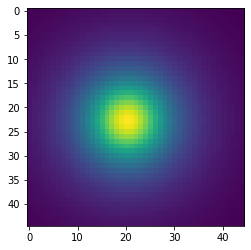

In [24]:
p_init = models.Moffat2D(amplitude = amp_Hb, x_0=x0, y_0=y0,gamma=3,alpha=3)
f = fitting.LevMarLSQFitter()
p = f(p_init, x, y, Hb)
res = Hb - p(x,y)
plt.imshow(p(x,y))
plt.show()

In [26]:
[amp1,x1, y1,gamma1,alpha1] = p.parameters
print(amp1)

251.96212998915118


In [27]:
gamma_fix = gamma1
alpha_fix = alpha1

In [28]:
[y0,x0]= ndimage.measurements.maximum_position(OIII)#Find the positions of the maximums of the values of an array at labels.

In [29]:
p_init = models.Moffat2D(amplitude = amp_OIII, x_0=x0, y_0=y0,gamma=gamma1,alpha=alpha1,fixed={'gamma':True,'alpha':True})                     
f = fitting.LevMarLSQFitter()
p_br = f(p_init, x, y, OIII)
res = OIII - p_br(x,y)

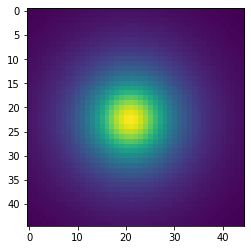

In [30]:
plt.imshow(p_br(x,y))
plt.show()

In [31]:
[amp2,x2,y2,gamma2,alpha2] = p_br.parameters
print(amp2)

67.51262808722046


In [32]:
hdus=[]
hdus.append(fits.PrimaryHDU())
hdus.append(fits.ImageHDU(p(x,y),name='Hb'))
hdus.append(fits.ImageHDU(p_br(x,y),name='OIII'))
hdu = fits.HDUList(hdus)
hdu.writeto('moffat_model_3C264_HbO3.fits',overwrite='True')

In [37]:
outflow_size_pix = np.sqrt((x2 -  x1)**2 + (y2 -  y1)**2)
outflow_size_arc = 0.4*outflow_size_pix   
print("Centroid Difference size in Arcseconds: ",outflow_size_arc)

Centroid Difference size in Arcseconds:  0.2504712023068816


In [38]:
distance = central_vel/70  # hubble law
outflow_size_parsec = (distance*outflow_size_arc)*4.848
print("Outflow Offset size in Parsecs:  ",outflow_size_parsec)

Outflow Offset size in Parsecs:   113.03252967592847


In [49]:
v_out = np.abs(popt[10]-popt[8])
M_dot = 3*(v_out/100)*(M_ion/10**7)*(1/(outflow_size_parsec/1000))
print(M_dot)

1.911877264738091e-06
